In [4]:
from dolphindb import session
import numpy as np
import pandas as pd
import json
from datetime import datetime, timedelta
import sys
import os
import traceback
from scipy.interpolate import CubicSpline
import yfinance as yf
# Import libraries for data visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
from datetime import datetime, timedelta
import warnings

# Set the style for plotting
plt.style.use('fivethirtyeight')
sns.set_palette('colorblind')

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [ ]:
def get_data(ticker=None, period='2y', interval='1h'):
    """
    Get stock data from Yahoo Finance
    
    Parameters:
    ticker (str): Ticker symbol (e.g., 'PETR4.SA')
    period (str): Period to download ('1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max')
    interval (str): Data interval ('1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo')
    
    Returns:
    DataFrame: DataFrame with OHLCV data
    """
    if ticker is None:
        return None
    
    try:
        data = yf.download(ticker, period=period, interval=interval, progress=False)
        
        if data.empty:
            print(f"No data found for {ticker}")
            return None
        
        # Check if we got a MultiIndex DataFrame (happens with group_by='ticker')
        if isinstance(data.columns, pd.MultiIndex):
            print(f"Detected MultiIndex columns, flattening index structure...")
            # If it's just one ticker, we can flatten the columns
            if ticker and ',' not in ticker:
                # Create a flat DataFrame with single-level column names
                flat_data = pd.DataFrame()
                for col_name in ['Open', 'High', 'Low', 'Close', 'Volume']:
                    if (col_name, ticker) in data.columns:
                        flat_data[col_name] = data[(col_name, ticker)]
                    elif col_name in data.columns.get_level_values(0):
                        # Find the right column if ticker doesn't match exactly
                        for second_level in data.columns.get_level_values(1).unique():
                            if (col_name, second_level) in data.columns:
                                flat_data[col_name] = data[(col_name, second_level)]
                                break
                
                # Ensure we have the index (dates/times)
                flat_data.index = data.index
                data = flat_data
            else:
                # For multiple tickers, we'll need a different approach
                # Just flatten column names with a join for now
                data.columns = [f"{col[0]}_{col[1]}" for col in data.columns]
        
        # Convert index to column for further processing
        transformed_data = data.copy()
        transformed_data.reset_index(inplace=True)
        
        # Ensure Datetime column exists and is named correctly
        if 'index' in transformed_data.columns:
            transformed_data.rename(columns={'index': 'Datetime'}, inplace=True)
        elif 'Date' in transformed_data.columns:
            transformed_data.rename(columns={'Date': 'Datetime'}, inplace=True)
            
        transformed_data['Symbol'] = ticker
        
        return transformed_data
    
    except Exception as e:
        print(f"Error downloading data: {str(e)}")
        traceback.print_exc()
        return None
    
def calculate_returns(data, ticker, period, iterations, forecast_days, hours_per_day=7):
    """
    Calculate returns and run Monte Carlo bootstrap simulation on hourly data
    
    Parameters:
    data (DataFrame): DataFrame with OHLCV data from yfinance
    ticker (str): Ticker symbol
    period (str): Period for historical data analysis
    iterations (int): Number of Monte Carlo iterations
    forecast_days (int): Number of days to forecast
    hours_per_day (int): Average number of trading hours per day, default is 7
    
    Returns:
    dict: Results of the Monte Carlo simulation
    """
    # Copy the dataframe to avoid modifying the original
    asset_df = data.copy()
    
    # Check if we have the right columns and structure
    print(f"DataFrame columns: {asset_df.columns.tolist()}")
    print(f"DataFrame shape: {asset_df.shape}")
    
    # Handle MultiIndex columns if they exist
    if isinstance(asset_df.columns, pd.MultiIndex):
        print("Converting MultiIndex columns to flat structure...")
        # Find the Close column in the MultiIndex
        close_col = None
        for col in asset_df.columns:
            if isinstance(col, tuple) and col[0] == 'Close':
                close_col = col
                break
        
        if close_col:
            # Extract Close price and create a new flat DataFrame
            asset_df = pd.DataFrame({
                'Close': asset_df[close_col],
                'Datetime': asset_df.index if 'Datetime' not in asset_df.columns else asset_df['Datetime']
            })
        else:
            raise ValueError(f"Could not find Close price column in MultiIndex columns: {asset_df.columns.tolist()}")
    
    # Ensure 'Close' exists in the data with proper capitalization
    if 'Close' not in asset_df.columns:
        if 'close' in asset_df.columns:
            asset_df['Close'] = asset_df['close']
        else:
            # Try to find a column that might be the close price
            close_candidates = [col for col in asset_df.columns if 'close' in str(col).lower()]
            if close_candidates:
                asset_df['Close'] = asset_df[close_candidates[0]]
            else:
                raise ValueError(f"No Close price column found in data. Available columns: {asset_df.columns.tolist()}")
    
    # Calculate returns
    asset_df['simple_return'] = asset_df['Close'].pct_change()
    asset_df['log_return'] = np.log(1 + asset_df['simple_return'])
    
    # Before dropping NaN values, verify column existence
    if 'simple_return' not in asset_df.columns or 'log_return' not in asset_df.columns:
        print("Warning: Return columns not created properly. Column list:", asset_df.columns.tolist())
        # Re-attempt column creation with explicit column names
        asset_df.loc[:, 'simple_return'] = asset_df['Close'].pct_change()
        asset_df.loc[:, 'log_return'] = np.log(1 + asset_df['simple_return'])
    
    # Now it's safe to drop NaN values as we've created the columns
    asset_df = asset_df.dropna(subset=['simple_return', 'log_return'])
    
    # Check if we have enough data after cleaning
    if len(asset_df) < 30:  # Arbitrary minimum, adjust as needed
        raise ValueError(f"Not enough data points after cleaning: {len(asset_df)} rows")
    
    # Get empirical distribution of returns
    cdf_values = calculate_cdf_values(asset_df)
    
    # Run Monte Carlo simulation
    # Calculate time_steps as hours_per_day * forecast_days
    time_steps = hours_per_day * forecast_days
    mc_results = mc_bootstrap(
        cdf_values['S0'], 
        cdf_values['interpolated_cdf_values'], 
        cdf_values['sorted_values'], 
        time_steps=time_steps, 
        iterations=iterations,
        hours_per_day=hours_per_day
    )
    
    # Prepare results
    results = {
        'ticker': ticker,
        'last_price': float(cdf_values['S0']),
        'historical_stats': {
            'mean_return': float(asset_df['simple_return'].mean()),
            'std_return': float(asset_df['simple_return'].std()),
            'median_return': float(asset_df['simple_return'].median()),
            'skew': float(asset_df['simple_return'].skew()),
            'kurtosis': float(asset_df['simple_return'].kurtosis())
        },
        'monte_carlo': mc_results
    }
    
    return results, asset_df

def calculate_cdf_values(asset_df):
    """
    Calculate the CDF values for the empirical distribution of log returns
    
    Parameters:
    asset_df (DataFrame): DataFrame with log_return column
    
    Returns:
    dict: CDF values and related statistics
    """
    # Ensure we have log_return column
    if 'log_return' not in asset_df.columns:
        raise ValueError("log_return column not found in data")
    
    # Get unique sorted values of log returns
    sorted_values = np.unique(np.sort(asset_df['log_return']))
    
    # Calculate empirical CDF
    ecdf = np.arange(1, len(sorted_values) + 1) / len(sorted_values)
    
    # Use cubic spline for interpolation
    cs = CubicSpline(sorted_values, ecdf)
    interpolated_cdf_values = cs(sorted_values)

    # Ensure arrays have same length
    min_length = min(len(sorted_values), len(interpolated_cdf_values))
    sorted_values = sorted_values[:min_length]
    interpolated_cdf_values = interpolated_cdf_values[:min_length]
    
    # Calculate survival function (1-CDF)
    sf_interpolated = 1 - interpolated_cdf_values
    
    # Get last price
    S0 = asset_df['Close'].iloc[-1]
    
    # Get median log return
    mu = np.median(asset_df['log_return'])

    return {
        'S0': float(S0),
        'sf_interpolated': sf_interpolated.tolist(),
        'sorted_values': sorted_values.tolist(),
        'interpolated_cdf_values': interpolated_cdf_values.tolist(),
        'mu': float(mu)
    }

def mc_bootstrap(S0, cdf_empirical_interpolated, sorted_values, time_steps, iterations, hours_per_day=7):
    """
    Run Monte Carlo bootstrap simulation with hourly data aggregated to daily paths.
    
    Parameters:
    S0 (float): Starting price
    cdf_empirical_interpolated (list): Interpolated CDF values
    sorted_values (list): Sorted log returns
    time_steps (int): Number of hourly steps to simulate
    iterations (int): Number of Monte Carlo iterations
    hours_per_day (int): Average number of trading hours per day
    
    Returns:
    dict: Simulation results including both hourly and daily paths
    """
    # Convert lists to numpy arrays if they aren't already
    cdf_empirical_interpolated = np.array(cdf_empirical_interpolated)
    sorted_values = np.array(sorted_values)
    
    def _run_simulation(time_steps, iterations):
        # Generate random numbers from uniform distribution
        U = np.random.rand(time_steps, iterations)
        
        # Transform to match empirical distribution using inverse transform sampling
        Z = np.interp(U, cdf_empirical_interpolated, sorted_values)
        
        # Convert log returns to simple returns
        factor = np.exp(Z)
        
        # Hourly paths calculation
        hourly_paths = S0 * np.cumprod(factor, axis=0)
        
        # Reshape to get daily paths (assuming hours_per_day trading hours per day)
        days = time_steps // hours_per_day
        remainder = time_steps % hours_per_day
        
        # Add padding if needed to make the array divisible by hours_per_day
        if remainder > 0:
            padding = hours_per_day - remainder
            # Repeat the last row for padding
            pad = np.tile(hourly_paths[-1, :], (padding, 1))
            hourly_paths = np.vstack([hourly_paths, pad])
            time_steps_adjusted = time_steps + padding
        else:
            time_steps_adjusted = time_steps
        
        # Reshape to (days, hours_per_day, iterations) and get daily closing prices
        reshaped_paths = hourly_paths.reshape(time_steps_adjusted // hours_per_day, hours_per_day, iterations)
        daily_paths = reshaped_paths[:, -1, :] # Take the last hour of each day
        
        # Final values
        arrival_values = daily_paths[-1, :]
        
        return hourly_paths, daily_paths, arrival_values
    
    hourly_paths, daily_paths, arrival_values = _run_simulation(time_steps, iterations)
    
    # Calculate statistics for the final values
    stats = {
        'mean': float(np.mean(arrival_values)),
        'median': float(np.median(arrival_values)),
        'std': float(np.std(arrival_values)),
        'min': float(np.min(arrival_values)),
        'max': float(np.max(arrival_values)),
        'percentiles': {
            '1%': float(np.percentile(arrival_values, 1)),
            '5%': float(np.percentile(arrival_values, 5)),
            '25%': float(np.percentile(arrival_values, 25)),
            '75%': float(np.percentile(arrival_values, 75)),
            '95%': float(np.percentile(arrival_values, 95)),
            '99%': float(np.percentile(arrival_values, 99))
        }
    }
    
    # Save a subset of paths for visualization
    sample_size = min(100, iterations)
    indices = np.random.choice(iterations, sample_size, replace=False)
    
    return {
        'stats': stats,
        'hourly_paths': hourly_paths[:, indices].tolist(),  # Sample paths for plotting
        'daily_paths': daily_paths[:, indices].tolist(),    # Daily paths for plotting
        'path_count': sample_size,
        'days': time_steps // hours_per_day,
        'hours_per_day': hours_per_day,
        'total_iterations': iterations  # Add total iterations to the results
    }

def run_bootstrap(ticker, period_str, iterations, forecast_days, hours_per_day=7):
    """
    Runs the bootstrap simulation for a given ticker
    
    Parameters:
    ticker (str): Ticker symbol
    period_str (str): Period for historical data in yfinance format (e.g., '1y', '2y')
    iterations (int): Number of Monte Carlo iterations
    forecast_days (int): Number of days to forecast
    hours_per_day (int): Average trading hours per day
    
    Returns:
    dict: Simulation results
    """
    try:
        # Download data directly via yfinance
        print(f"Downloading data for {ticker} with period={period_str}, interval=1h")
        data = get_data(ticker, period=period_str, interval='1h')
        
        if data is None or len(data) == 0:
            raise Exception(f"Failed to query data for {ticker}")
            
        print(f"Downloaded {len(data)} records")
        
        # Run the bootstrap simulation
        results, asset_df = calculate_returns(data, ticker, period_str, iterations, forecast_days, hours_per_day)
        return results, asset_df, data

    except Exception as e:
        print(f"Error in bootstrap execution: {str(e)}", file=sys.stderr)
        print(traceback.format_exc(), file=sys.stderr)
        raise

In [6]:
# Define parameters
ticker = 'PETR4.SA'  # Brazilian stock - Petrobras
time_frame = '1h'
period = '2y'
iterations = 1000
forecast_days = 30  # Forecast for the next 30 days
hours_per_day = 7  # Based on the data analysis that shows ~7 trading hours per day

# Run the simulation
print(f"Running Monte Carlo bootstrap for {ticker} with {iterations} iterations over {forecast_days} days")
try:
    results, asset_df, raw_data = run_bootstrap(ticker, period, iterations, forecast_days, hours_per_day)
    print("Simulation completed successfully!")
except Exception as e:
    print(f"Error running simulation: {str(e)}")
    raise

Running Monte Carlo bootstrap for PETR4.SA with 1000 iterations over 30 days
Detected MultiIndex columns, flattening index structure...
Downloaded 3489 records
DataFrame columns: ['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume', 'Symbol']
DataFrame shape: (3489, 7)
Simulation completed successfully!
Detected MultiIndex columns, flattening index structure...
Downloaded 3489 records
DataFrame columns: ['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume', 'Symbol']
DataFrame shape: (3489, 7)
Simulation completed successfully!


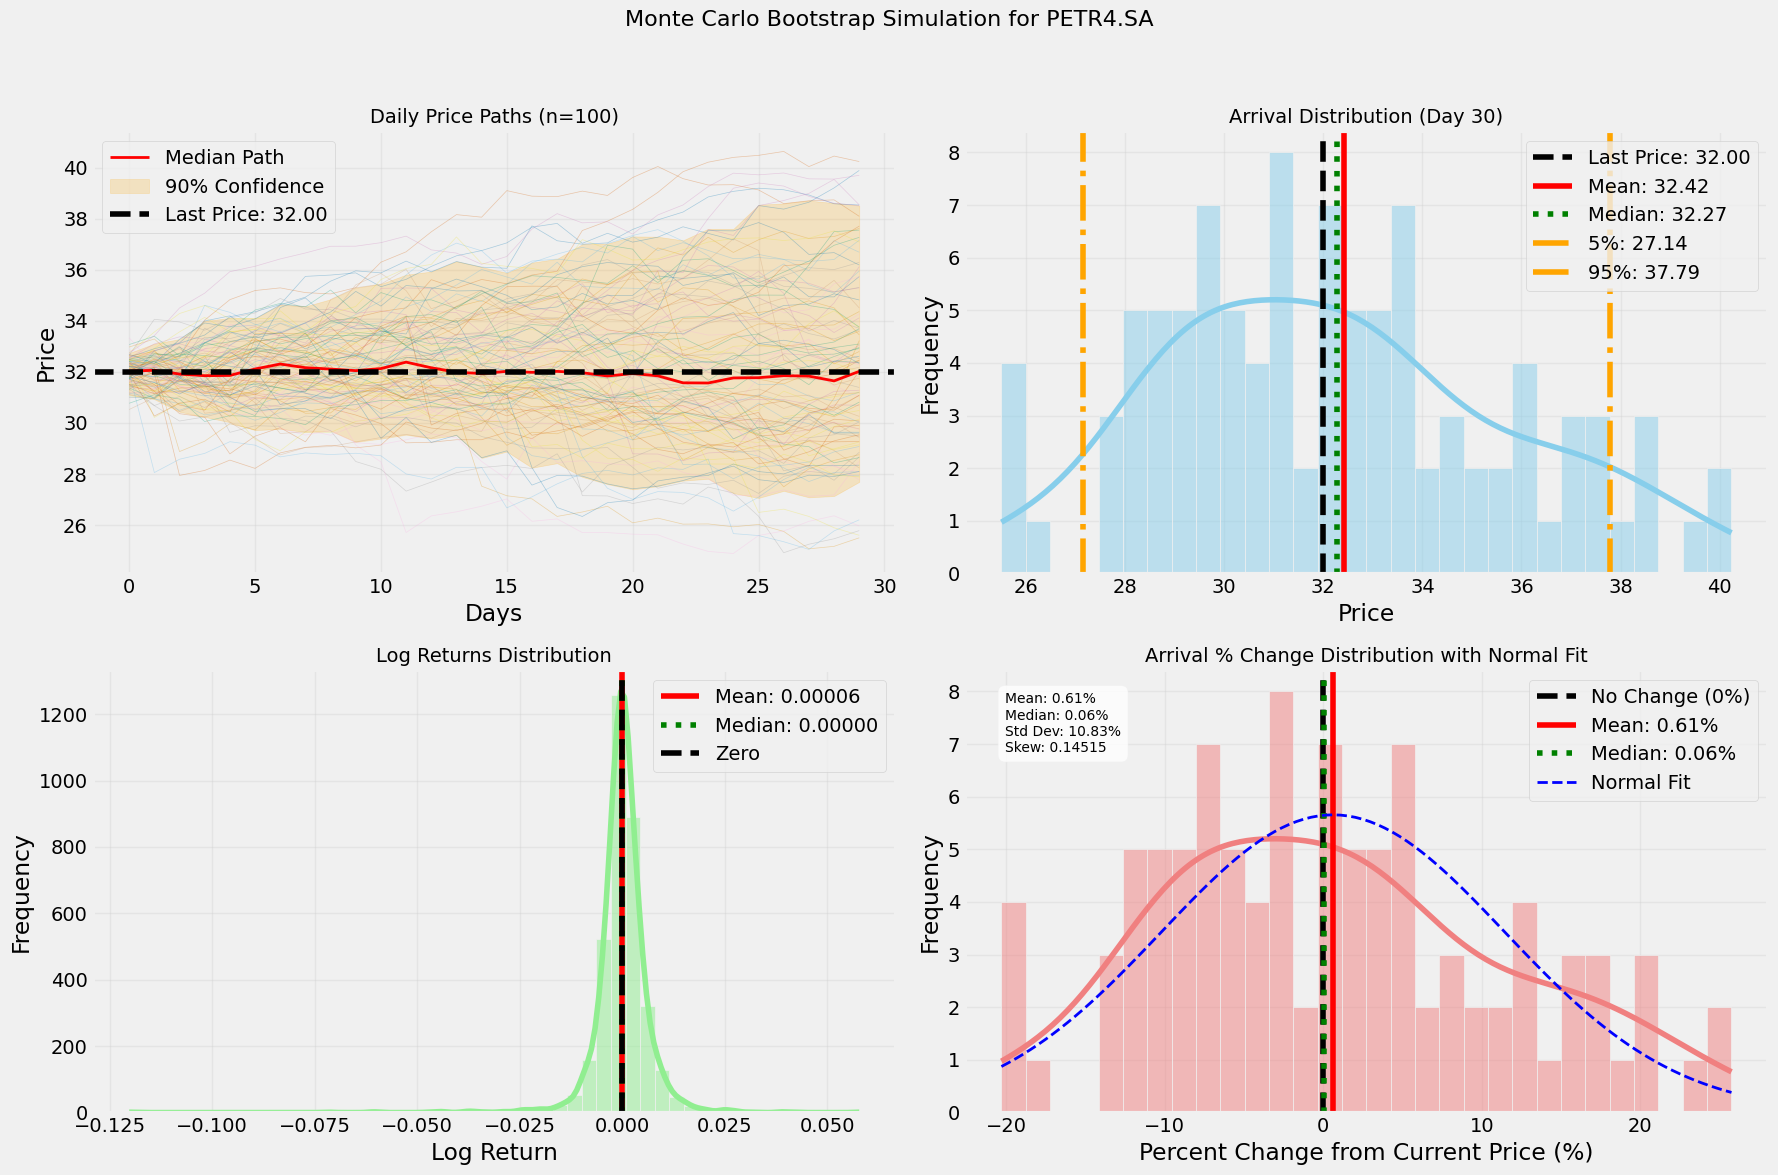


Monte Carlo Bootstrap Analysis for PETR4.SA
Current Price: $32.00
Forecast Period: 30 days
Number of Iterations: 1000

Arrival Price Statistics:
  Mean: $32.42 (0.61%)
  Median: $32.27 (0.06%)
  Std Dev: $3.29 (10.83%)

Percentiles:
  1%: $25.54 (-20.20%)
  5%: $27.14 (-15.18%)
  25%: $30.06 (-6.06%)
  75%: $34.83 (8.84%)
  95%: $37.79 (18.08%)
  99%: $39.92 (24.75%)

Fitting distributions to arrival prices:
  norm: KS=0.0640, p-value=0.7826
  lognorm: KS=0.0468, p-value=0.9738
  gamma: KS=0.0455, p-value=0.9799
  beta: KS=0.0679, p-value=0.7201
  t: KS=0.0641, p-value=0.7821
  cauchy: KS=0.1110, p-value=0.1580

Best fitting distribution: gamma
  KS statistic: 0.0455
  p-value: 0.9799


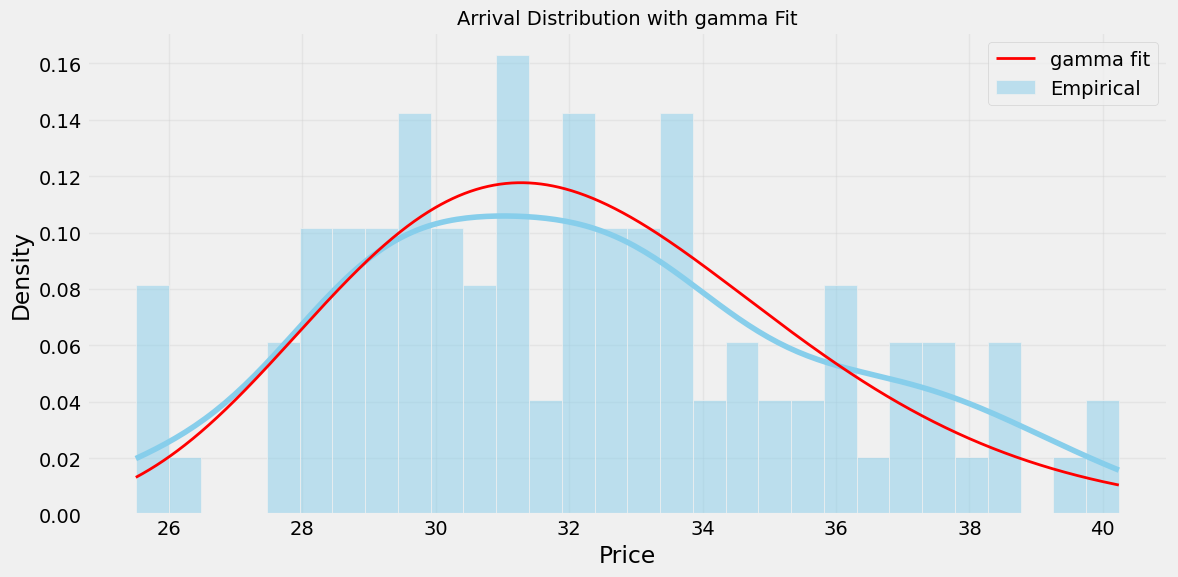

In [ ]:
# Visualization of Monte Carlo Paths
def plot_mc_paths(results, raw_data, title=None):
    '''
    Plot Monte Carlo simulation paths and arrival distribution
    '''
    # Extract data from results
    daily_paths = np.array(results['monte_carlo']['daily_paths'])
    hourly_paths = np.array(results['monte_carlo']['hourly_paths'])
    path_count = results['monte_carlo']['path_count']
    last_price = results['last_price']
    days = results['monte_carlo']['days']
    ticker = results['ticker']
    
    # Get the total number of iterations from results
    total_iterations = results.get('total_iterations', path_count)
    
    # Set up the plot
    plt.figure(figsize=(18, 12))
    plt.suptitle(f"Monte Carlo Bootstrap Simulation for {ticker} (Total Iterations: {total_iterations:,})", fontsize=16)
    
    # 1. Plot Daily Paths
    plt.subplot(2, 2, 1)
    time_axis = np.arange(daily_paths.shape[0])
    
    # Plot each path
    for i in range(path_count):
        plt.plot(time_axis, daily_paths[:, i], linewidth=0.5, alpha=0.3)
    
    # Plot the median path with thicker line
    median_path = np.median(daily_paths, axis=1)
    plt.plot(time_axis, median_path, 'r-', linewidth=2, label='Median Path')
    
    # Plot quantiles (5% and 95%)
    q05 = np.percentile(daily_paths, 5, axis=1)
    q95 = np.percentile(daily_paths, 95, axis=1)
    plt.fill_between(time_axis, q05, q95, color='orange', alpha=0.2, label='90% Confidence')
    
    plt.axhline(y=last_price, color='k', linestyle='--', label=f'Last Price: {last_price:.2f}')
    
    plt.title(f"Daily Price Paths (Showing {path_count} of {total_iterations:,} paths)", fontsize=14)
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Plot Arrival Distribution
    plt.subplot(2, 2, 2)
    
    # Get arrival values
    arrival_values = daily_paths[-1, :]
    
    # Plot histogram
    sns.histplot(arrival_values, kde=True, bins=30, color='skyblue')
    
    # Add vertical lines for statistics
    plt.axvline(x=last_price, color='k', linestyle='--', label=f'Last Price: {last_price:.2f}')
    plt.axvline(x=results['monte_carlo']['stats']['mean'], color='r', linestyle='-', label=f"Mean: {results['monte_carlo']['stats']['mean']:.2f}")
    plt.axvline(x=results['monte_carlo']['stats']['median'], color='g', linestyle=':', label=f"Median: {results['monte_carlo']['stats']['median']:.2f}")
    plt.axvline(x=results['monte_carlo']['stats']['percentiles']['5%'], color='orange', linestyle='-.', label=f"5%: {results['monte_carlo']['stats']['percentiles']['5%']:.2f}")
    plt.axvline(x=results['monte_carlo']['stats']['percentiles']['95%'], color='orange', linestyle='-.', label=f"95%: {results['monte_carlo']['stats']['percentiles']['95%']:.2f}")
    
    plt.title(f"Arrival Distribution (Day {days})", fontsize=14)
    plt.xlabel("Price")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. Plot Log Returns Distribution
    plt.subplot(2, 2, 3)
    log_returns = asset_df['log_return']
    
    # Plot histogram
    sns.histplot(log_returns, kde=True, bins=50, color='lightgreen')
    
    # Add statistics
    plt.axvline(x=log_returns.mean(), color='r', linestyle='-', label=f"Mean: {log_returns.mean():.5f}")
    plt.axvline(x=log_returns.median(), color='g', linestyle=':', label=f"Median: {log_returns.median():.5f}")
    plt.axvline(x=0, color='k', linestyle='--', label='Zero')
    
    plt.title("Log Returns Distribution", fontsize=14)
    plt.xlabel("Log Return")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. Fit a distribution to arrival values
    plt.subplot(2, 2, 4)
    
    # Calculate percent changes from last price
    percent_changes = (arrival_values - last_price) / last_price * 100
    
    # Plot histogram of percent changes
    sns.histplot(percent_changes, kde=True, bins=30, color='lightcoral')
    
    # Calculate statistics
    mean_pct = np.mean(percent_changes)
    median_pct = np.median(percent_changes)
    std_pct = np.std(percent_changes)
    skew_pct = results['monte_carlo']['stats']['mean'] - results['monte_carlo']['stats']['median']
    
    # Add vertical lines for statistics
    plt.axvline(x=0, color='k', linestyle='--', label='No Change (0%)')
    plt.axvline(x=mean_pct, color='r', linestyle='-', label=f"Mean: {mean_pct:.2f}%")
    plt.axvline(x=median_pct, color='g', linestyle=':', label=f"Median: {median_pct:.2f}%")
    
    # Try to fit a normal distribution
    from scipy import stats
    x = np.linspace(np.min(percent_changes), np.max(percent_changes), 100)
    normal_pdf = stats.norm.pdf(x, mean_pct, std_pct)
    plt.plot(x, normal_pdf * len(percent_changes) * (x.max() - x.min()) / 30, 'b--', linewidth=2, label='Normal Fit')
    
    # Add text with distribution statistics
    info_text = (f"Mean: {mean_pct:.2f}%\n"
                f"Median: {median_pct:.2f}%\n"
                f"Std Dev: {std_pct:.2f}%\n"
                f"Skew: {skew_pct:.5f}")
    
    plt.annotate(info_text, xy=(0.05, 0.95), xycoords='axes fraction',
                fontsize=10, bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8),
                va='top', ha='left')
    
    plt.title("Arrival % Change Distribution with Normal Fit", fontsize=14)
    plt.xlabel("Percent Change from Current Price (%)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Adjust layout and display plot
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    # Return key statistics for further analysis
    return {
        'arrival_values': arrival_values,
        'percent_changes': percent_changes,
        'mean_pct': mean_pct,
        'median_pct': median_pct,
        'std_pct': std_pct,
        'skew': skew_pct
    }

# Plot the Monte Carlo simulation results
try:
    plot_stats = plot_mc_paths(results, raw_data)

    # Print summary of the analysis
    print(f"\n{'='*50}")
    print(f"Monte Carlo Bootstrap Analysis for {ticker}")
    print(f"{'='*50}")
    print(f"Current Price: ${results['last_price']:.2f}")
    print(f"Forecast Period: {forecast_days} days")
    print(f"Number of Iterations: {results['monte_carlo'].get('total_iterations', iterations):,}")
    print(f"Paths Displayed: {results['monte_carlo']['path_count']:,}")
    print("\nArrival Price Statistics:")
    print(f"  Mean: ${results['monte_carlo']['stats']['mean']:.2f} ({plot_stats['mean_pct']:.2f}%)")
    print(f"  Median: ${results['monte_carlo']['stats']['median']:.2f} ({plot_stats['median_pct']:.2f}%)")
    print(f"  Std Dev: ${results['monte_carlo']['stats']['std']:.2f} ({plot_stats['std_pct']:.2f}%)")
    print("\nPercentiles:")
    for p, v in results['monte_carlo']['stats']['percentiles'].items():
        pct_change = (v - results['last_price']) / results['last_price'] * 100
        print(f"  {p}: ${v:.2f} ({pct_change:.2f}%)")

    # Additional statistical fit tests
    from scipy import stats

    # Test several distributions to find the best fit
    arr_vals = plot_stats['arrival_values']
    distributions = ['norm', 'lognorm', 'gamma', 'beta', 't', 'cauchy']
    best_fit = {'name': '', 'kstest': float('inf')}

    print("\nFitting distributions to arrival prices:")
    for dist_name in distributions:
        try:
            # Fit the distribution
            params = getattr(stats, dist_name).fit(arr_vals)
            # Perform Kolmogorov-Smirnov test
            ks_stat, p_value = stats.kstest(arr_vals, dist_name, params)
            
            print(f"  {dist_name}: KS={ks_stat:.4f}, p-value={p_value:.4f}")
            
            # Keep track of the best fitting distribution
            if ks_stat < best_fit['kstest']:
                best_fit = {'name': dist_name, 'kstest': ks_stat, 'p_value': p_value, 'params': params}
        except Exception as e:
            print(f"  {dist_name}: Failed to fit - {str(e)}")

    print(f"\nBest fitting distribution: {best_fit['name']}")
    print(f"  KS statistic: {best_fit['kstest']:.4f}")
    print(f"  p-value: {best_fit['p_value']:.4f}")

    # Plot the best fitting distribution against the empirical data
    plt.figure(figsize=(12, 6))

    # Histogram of arrival values
    sns.histplot(arr_vals, kde=True, stat='density', label='Empirical', bins=30, color='skyblue')

    # Generate x values for the PDF
    x = np.linspace(min(arr_vals), max(arr_vals), 1000)

    # Get the PDF of the best fitting distribution
    best_dist = getattr(stats, best_fit['name'])
    pdf = best_dist.pdf(x, *best_fit['params'][:-2], loc=best_fit['params'][-2], scale=best_fit['params'][-1])

    # Plot the PDF
    plt.plot(x, pdf, 'r-', linewidth=2, label=f"{best_fit['name']} fit")

    plt.title(f"Arrival Distribution with {best_fit['name']} Fit", fontsize=14)
    plt.xlabel("Price")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error plotting results: {str(e)}")
    traceback.print_exc()

# Extensive Testing Section

This section provides comprehensive tests for all the functions in the Monte Carlo bootstrap simulation. Each test provides insights into how the functions work and what outputs they produce.

In [8]:
# Comprehensive testing of each function in the Monte Carlo bootstrap model

def test_get_data():
    """Test the get_data function with different tickers and parameters"""
    print("\n===== Testing get_data function =====")
    
    # Test with different assets
    test_tickers = ['AAPL', 'MSFT', 'PETR4.SA', '^BVSP']  # US stocks, Brazilian stock, and Bovespa index
    test_periods = ['1mo', '3mo', '1y']
    test_intervals = ['1d', '1h']
    
    results = {}
    
    for ticker in test_tickers:
        print(f"\nTesting ticker: {ticker}")
        for period in test_periods:
            for interval in test_intervals:
                print(f"  Getting {period} data with {interval} interval...", end="")
                data = get_data(ticker, period=period, interval=interval)
                
                if data is not None:
                    print(f" Success! Downloaded {len(data)} records")
                    # Store the result for the longest period for later use
                    if period == '1y' and interval == '1h':
                        results[ticker] = data
                else:
                    print(" Failed!")
    
    print("\nData retrieval test complete.")
    return results

def test_calculate_returns(data_dict):
    """Test the calculate_returns function with different data"""
    print("\n===== Testing calculate_returns function =====")
    
    test_results = {}
    
    for ticker, data in data_dict.items():
        print(f"\nTesting with {ticker} data")
        try:
            # Set fixed parameters for testing
            period = '1y'
            iterations = 100
            forecast_days = 7
            hours_per_day = 7
            
            results, asset_df = calculate_returns(data, ticker, period, iterations, forecast_days, hours_per_day)
            
            print(f"  Success! Calculated returns for {ticker}")
            print(f"  Data shape after cleaning: {asset_df.shape}")
            print(f"  Statistical summary:")
            print(f"    Mean return: {results['historical_stats']['mean_return']:.6f}")
            print(f"    Std return: {results['historical_stats']['std_return']:.6f}")
            print(f"    Skewness: {results['historical_stats']['skew']:.6f}")
            
            test_results[ticker] = results
        except Exception as e:
            print(f"  Error calculating returns: {str(e)}")
    
    print("\nReturn calculation test complete.")
    return test_results

def test_cdf_calculation(data_dict):
    """Test the CDF calculation function"""
    print("\n===== Testing calculate_cdf_values function =====")
    
    for ticker, data in data_dict.items():
        print(f"\nTesting with {ticker} data")
        try:
            # Process data to prepare for CDF calculation
            asset_df = data.copy()
            if 'Close' not in asset_df.columns and 'close' in asset_df.columns:
                asset_df['Close'] = asset_df['close']
            
            asset_df['simple_return'] = asset_df['Close'].pct_change()
            asset_df['log_return'] = np.log(1 + asset_df['simple_return'])
            asset_df = asset_df.dropna(subset=['simple_return', 'log_return'])
            
            # Calculate CDF
            cdf_values = calculate_cdf_values(asset_df)
            
            print(f"  Success! Calculated CDF for {ticker}")
            print(f"  CDF statistics:")
            print(f"    Last price (S0): {cdf_values['S0']:.2f}")
            print(f"    Median log return (mu): {cdf_values['mu']:.6f}")
            print(f"    Number of unique return values: {len(cdf_values['sorted_values'])}")
            
            # Visualize the empirical CDF
            plt.figure(figsize=(10, 6))
            plt.plot(cdf_values['sorted_values'], cdf_values['interpolated_cdf_values'], 'b-', linewidth=1)
            plt.title(f"Empirical CDF of Log Returns for {ticker}")
            plt.xlabel("Log Return")
            plt.ylabel("Cumulative Probability")
            plt.grid(True, alpha=0.3)
            plt.show()
            
        except Exception as e:
            print(f"  Error calculating CDF: {str(e)}")
    
    print("\nCDF calculation test complete.")

def test_mc_bootstrap():
    """Test the Monte Carlo bootstrap function with synthetic data"""
    print("\n===== Testing mc_bootstrap function =====")
    
    # Create synthetic data for testing
    print("Creating synthetic data for MC bootstrap test...")
    
    # Simulate log returns from a normal distribution
    np.random.seed(42)  # For reproducibility
    n_samples = 1000
    mu = 0.0001
    sigma = 0.01
    log_returns = np.random.normal(mu, sigma, n_samples)
    
    # Sort values and create CDF
    sorted_values = np.sort(log_returns)
    cdf_values = np.linspace(0, 1, len(sorted_values))
    
    # Run MC bootstrap with different parameters
    test_cases = [
        {"name": "Small test", "S0": 100, "time_steps": 7, "iterations": 100, "hours_per_day": 7},
        {"name": "Medium test", "S0": 100, "time_steps": 70, "iterations": 500, "hours_per_day": 7},
        {"name": "Large test", "S0": 100, "time_steps": 210, "iterations": 1000, "hours_per_day": 7}
    ]
    
    for test in test_cases:
        print(f"\nRunning {test['name']}:")
        print(f"  Parameters: S0={test['S0']}, time_steps={test['time_steps']}, iterations={test['iterations']}")
        
        start_time = datetime.now()
        results = mc_bootstrap(
            test['S0'], 
            cdf_values, 
            sorted_values, 
            test['time_steps'], 
            test['iterations'],
            test['hours_per_day']
        )
        elapsed = (datetime.now() - start_time).total_seconds()
        
        print(f"  Completed in {elapsed:.2f} seconds")
        print(f"  Results:")
        print(f"    Mean final price: {results['stats']['mean']:.2f}")
        print(f"    Median final price: {results['stats']['median']:.2f}")
        print(f"    5% percentile: {results['stats']['percentiles']['5%']:.2f}")
        print(f"    95% percentile: {results['stats']['percentiles']['95%']:.2f}")
        
        # Generate a simple visualization of paths
        daily_paths = np.array(results['daily_paths'])
        plt.figure(figsize=(10, 6))
        plt.plot(daily_paths, alpha=0.1)
        plt.title(f"MC Bootstrap Paths - {test['name']}")
        plt.xlabel("Time Steps")
        plt.ylabel("Price")
        plt.axhline(y=test['S0'], color='k', linestyle='--', label=f'Starting Price: {test["S0"]:.2f}')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()
    
    print("\nMC bootstrap test complete.")

def test_end_to_end():
    """Run a complete end-to-end test with multiple assets"""
    print("\n===== Running End-to-End Test =====")
    
    # Define test parameters
    test_tickers = ['AAPL', 'PETR4.SA', '^BVSP']
    period = '1y'
    iterations = 500
    forecast_days = 30
    hours_per_day = 7
    
    for ticker in test_tickers:
        print(f"\nRunning complete simulation for {ticker}")
        try:
            results, asset_df, raw_data = run_bootstrap(ticker, period, iterations, forecast_days, hours_per_day)
            
            print(f"Simulation successful for {ticker}")
            print(f"  Last price: ${results['last_price']:.2f}")
            print(f"  Forecast median price: ${results['monte_carlo']['stats']['median']:.2f}")
            print(f"  Forecast 5%-95% range: ${results['monte_carlo']['stats']['percentiles']['5%']:.2f} - "
                  f"${results['monte_carlo']['stats']['percentiles']['95%']:.2f}")
            
            # Generate a simplified visualization
            plot_stats = plot_mc_paths(results, raw_data)
            
        except Exception as e:
            print(f"Error in end-to-end test for {ticker}: {str(e)}")
    
    print("\nEnd-to-end test complete.")

# Run all tests in sequence
print("Running comprehensive tests for Monte Carlo Bootstrap model")

# Uncomment these lines to run the tests
# test_data = test_get_data()
# if test_data:
#     test_results = test_calculate_returns(test_data)
#     test_cdf_calculation(test_data)
# test_mc_bootstrap()
# test_end_to_end()

print("\nAll tests complete!")

Running comprehensive tests for Monte Carlo Bootstrap model

All tests complete!


In [ ]:
# Example of using the model to compare different assets

def compare_assets(tickers, period='1y', iterations=500, forecast_days=30, hours_per_day=7):
    """
    Compare Monte Carlo simulations for multiple assets
    
    Parameters:
    tickers (list): List of ticker symbols
    period (str): Period for historical data
    iterations (int): Number of Monte Carlo iterations
    forecast_days (int): Number of days to forecast
    hours_per_day (int): Average trading hours per day
    
    Returns:
    dict: Simulation results for each ticker
    """
    results = {}
    
    # Run simulations for each ticker
    for ticker in tickers:
        print(f"\nRunning simulation for {ticker}...")
        try:
            ticker_results, asset_df, raw_data = run_bootstrap(ticker, period, iterations, forecast_days, hours_per_day)
            results[ticker] = {
                'simulation': ticker_results,
                'raw_data': raw_data
            }
            print(f"Simulation completed for {ticker}")
        except Exception as e:
            print(f"Error simulating {ticker}: {str(e)}")
    
    # Create comparison visualization
    compare_results(results, forecast_days)
    
    return results

def compare_results(results, forecast_days):
    """
    Create a comparison visualization for multiple assets
    
    Parameters:
    results (dict): Simulation results for each ticker
    forecast_days (int): Number of days in the forecast
    """
    # Extract tickers
    tickers = list(results.keys())
    n_tickers = len(tickers)
    
    if n_tickers == 0:
        print("No results to compare")
        return
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    plt.suptitle(f"Monte Carlo Simulation Comparison - {forecast_days} Day Forecast", fontsize=16)
    
    # 1. Compare normalized price paths
    ax1 = axes[0, 0]
    
    for ticker in tickers:
        # Get median path
        daily_paths = np.array(results[ticker]['simulation']['monte_carlo']['daily_paths'])
        median_path = np.median(daily_paths, axis=1)
        
        # Normalize to starting price (100%)
        normalized_path = (median_path / median_path[0]) * 100
        
        # Plot
        ax1.plot(normalized_path, linewidth=2, label=ticker)
    
    ax1.axhline(y=100, color='k', linestyle='--', label='Starting Value (100%)')
    ax1.set_title("Normalized Median Price Paths", fontsize=14)
    ax1.set_xlabel("Days")
    ax1.set_ylabel("Normalized Price (%)")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Compare return distributions
    ax2 = axes[0, 1]
    
    for ticker in tickers:
        # Calculate percent change from current to forecast
        last_price = results[ticker]['simulation']['last_price']
        arrival_values = daily_paths[-1, :]
        percent_changes = (arrival_values - last_price) / last_price * 100
        
        # Plot KDE of percent changes
        sns.kdeplot(percent_changes, ax=ax2, label=ticker)
    
    ax2.axvline(x=0, color='k', linestyle='--', label='No Change (0%)')
    ax2.set_title("Forecasted Return Distributions", fontsize=14)
    ax2.set_xlabel("Percent Change from Current (%)")
    ax2.set_ylabel("Density")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Compare confidence intervals
    ax3 = axes[1, 0]
    
    # Create data for boxplot
    boxplot_data = []
    labels = []
    
    for ticker in tickers:
        # Get arrival values as percent changes
        last_price = results[ticker]['simulation']['last_price']
        arrival_values = daily_paths[-1, :]
        percent_changes = (arrival_values - last_price) / last_price * 100
        
        boxplot_data.append(percent_changes)
        labels.append(ticker)
   
    # Create boxplot
    ax3.boxplot(boxplot_data, labels=labels, showfliers=False)
    ax3.axhline(y=0, color='k', linestyle='--', label='No Change (0%)')
    ax3.set_title("Return Distribution Comparison", fontsize=14)
    ax3.set_ylabel("Percent Change from Current (%)")
    ax3.grid(True, alpha=0.3)
    
    # 4. Compare risk metrics
    ax4 = axes[1, 1]
    
    # Calculate risk metrics
    var_values = []
    expected_returns = []
    sharpe_ratios = []
    
    for ticker in tickers:
        # Get arrival values
        last_price = results[ticker]['simulation']['last_price']
        arrival_values = daily_paths[-1, :]
        returns = (arrival_values - last_price) / last_price
        
        # Calculate metrics
        expected_return = np.mean(returns)
        var_95 = np.percentile(returns, 5)  # 95% VaR
        std_dev = np.std(returns)
        sharpe = expected_return / std_dev if std_dev > 0 else 0
        
        var_values.append(abs(var_95) * 100)  # Convert to percentage and make positive
        expected_returns.append(expected_return * 100)  # Convert to percentage
        sharpe_ratios.append(sharpe)
    
    # Create bar chart for risk metrics
    x = np.arange(len(tickers))
    width = 0.25
    
    ax4.bar(x - width, expected_returns, width, label='Expected Return (%)')
    ax4.bar(x, var_values, width, label='Value at Risk (95%)')
    ax4.bar(x + width, sharpe_ratios, width, label='Sharpe Ratio')
    
    ax4.set_xticks(x)
    ax4.set_xticklabels(tickers)
    ax4.set_title("Risk-Return Metrics Comparison", fontsize=14)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Example usage:
# compare_assets(['AAPL', 'MSFT', 'GOOGL', 'AMZN'], period='1y', iterations=500, forecast_days=30)